<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2

C:\Users\julia\Documents\Imperial\DA_project


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pipeline
import seaborn as sns
sns.set()
from matplotlib.ticker import ScalarFormatter
sns.set_style("whitegrid")

#sns.set_palette("Dark2")


In [3]:
backbone = "experiments/time/best/Backbone/AE.csv"
df = pd.read_csv(backbone)
df.mse_DA.mean()

0.16650886679082172

In [4]:
in_csv_times = "experiments/time/best/time.csv"


df = pd.read_csv(in_csv_times)
df

,Unnamed: 0,model,num_params,time,time_online
0,0,tucodec_relu_vanilla,10590849,0.133231,0.129445
1,1,tucodec_prelu_next,2527361,0.058213,0.053725
2,2,RDB3_27_4,25572973,0.489038,0.466610
3,3,ResNeXt_27_1,3491437,0.177211,0.169302
4,4,RAB_4_next,1305387,0.129126,0.119203
5,5,GDRN_CBAM,4664774,0.104493,0.088289
6,6,Backbone,296553,0.091583,0.089724


In [5]:
in_csv_times = "experiments/time/best_gpu/time.csv"
df = pd.read_csv(in_csv_times)
df

,Unnamed: 0,model,num_params,time,time_online
0,0,tucodec_relu_vanilla,10590849,0.126646,0.120407
1,1,tucodec_prelu_next,2527361,0.094413,0.088066
2,2,RDB3_27_4,25572973,0.475317,0.451456
3,3,ResNeXt_27_1,3491437,0.195146,0.186719
4,4,RAB_4_next,1305387,0.171259,0.160355
5,5,GDRN_CBAM,4664774,0.132721,0.115549


In [6]:
nobs2 = "experiments/TSVD3/extra/modes32_2_obs.csv"
nobs25 = "experiments/TSVD3/extra/modes32_25_obs.csv"
nobs248 = "experiments/TSVD3/extra/modes32_248_obs.csv"
for fp in [nobs2, nobs25, nobs248]:
    
    df = pd.read_csv(fp)
    df = df.drop(0)
    time = df["time"].mean()
    mse = df["mse_DA"].mean()
    online_time = df["time_online"].mean()
    print(time, online_time, mse)

0.03557635083490489 0.03325688717316608 0.3613405424001736
0.03851857477304887 0.0362430993391543 0.17694666514088092
0.04075728022322363 0.038560403853046654 0.16800904750812576


Use a range of AEs, and a range of TSVD Tau and M 
AND non-preconditioned VarDA. Repeat this in the introduction.

In [23]:
modesdf = pd.read_csv("report/data/modesdf.csv")
nobsdf = pd.read_csv("report/data/nobsdf.csv")

out_fp = "report/figures/time_perf.png"
out_fp2 = "report/figures/time_perf_report.png"
out_fp3 = "report/figures/time_perf_report2.png"
in_csv = "report/data/DA_tables - perf_time.csv"


modesdf = pd.concat([modesdf, nobsdf], axis=0, ignore_index=True)

modesdf["da_mse"] = modesdf["mse_DA"]
#modesdf["Model"] =  "$\tau = {}, M = {}$".format(modesdf["Model"], modesdf["nobs"]) # $\tau = 32, M = 0.001n$
#modesdf["Formulation"] = "TSVD" if modesdf["modes"] == 791 else "3D-VarDA"


#get rid of values
drop_modes = [12, 150, 250, 350, 450, 550, 700]
drop_nobs = [4, 16, 32, 64, 128, 512, 2048, 8192, 16384, 32768, ]
drop_modes2 = list(set([12, 16, 32, 60, 100, 150, 250, 350, 450, 550, 700]))
drop_nobs2 = [32, 256, 1024, 4096, 2475]
modesdf = modesdf[~modesdf.modes.isin(drop_modes)]
modesdf = modesdf[~modesdf.nobs.isin(drop_nobs)]


modesdf = modesdf[(modesdf.nobs == 247520) | (~modesdf.modes.isin(drop_modes2))]
modesdf = modesdf[(modesdf.nobs != 247520) | (~modesdf.modes.isin([32]))]
modesdf = modesdf[(modesdf.nobs != 24750) | (~modesdf.modes.isin([1]))]
modesdf = modesdf[(modesdf.nobs == 2475) | (~modesdf.modes.isin([8, 6,]))]
modesdf = modesdf[(modesdf.modes == 791) | (~modesdf.nobs.isin(drop_nobs2))]
modesdf = modesdf[(modesdf.modes != 791) | (~modesdf.nobs.isin([8, 32, 256, 1024, 2475, 24750]))]
modesdf = modesdf[(modesdf.modes != 4) | (~modesdf.nobs.isin([1, 2, 4, 8, 65536, 131072]))]
#modesdf = modesdf[(modesdf.nobs != 24750)  ~modesdf.modes.isin(drop_modes2)]
#print(modesdf.nobs != 247520 & ~ modesdf.modes.isin(drop_modes2))

#drop duplicates
modesdf = modesdf.drop_duplicates(subset=["nobs", "modes"], keep='first')

modesdf.loc[modesdf["nobs"] == 247520, "nobs"] = r"n"
modesdf.loc[modesdf["nobs"] == 24750, "nobs"] = r"0.1n"
modesdf.loc[modesdf["nobs"] == 2475, "nobs"] = r"0.01n"

modesdf.loc[modesdf["modes"] != 791, 'Formulation'] = 'TSVD'  
modesdf.loc[modesdf["modes"] == 791, 'Formulation'] = '3D-VarDA'  
modesdf["Model"] = r"$\tau = " + modesdf["modes"].astype(str) + ", M = " + modesdf["nobs"].astype(str) + "$"


df = pd.read_csv(in_csv)

## add modesdf data
df = pd.concat([df, modesdf], axis=0, join="inner", ignore_index=True)
print(df.shape, df.columns)
df

(23, 4) Index(['Model', 'da_mse', 'time', 'Formulation'], dtype='object')


,Model,da_mse,time,Formulation
0,Tucodec-vanilla,0.080900,0.129400,CAE
1,Tucodec-NeXt,0.078700,0.053700,CAE
2,RDB3-27-4-vanilla+CBAM,0.159400,0.466600,CAE
3,ResNeXt3-27-1-vanilla+CBAM,0.154800,0.169300,CAE
4,RAB-4-NeXt,0.172300,0.119200,CAE
5,GRDN-NeXt+CBAM,0.124100,0.088300,CAE
6,Backbone,0.166500,0.089700,CAE
7,"$\tau = 32, M=n$",0.127000,1.860000,TSVD
8,"$\tau = 32, M= 0.01n$",0.133400,0.044000,TSVD
9,"$\tau = 100, M = n$",0.092959,2.455707,TSVD


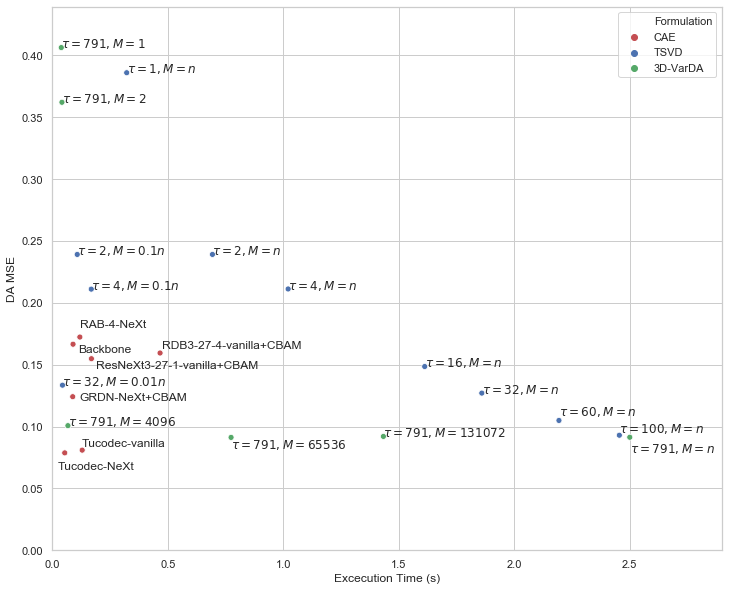

In [20]:
ax = sns.scatterplot(x="time", y="da_mse",
             hue="Formulation", #style="Subset", 
             data=df, palette=["r", "b", 'g',], marker="o")

x = df["time"].copy().astype(float)
y = df["da_mse"].copy().astype(float)
text = df["Model"]
ax.set_xlabel("Excecution Time (s)")
ax.set_ylabel("DA MSE")
xmin, xmax = 0.0, 2.9
ymin, ymax = 0, None
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
for i in range(len(df)):
    tex = r"{}".format(text[i]) 
    if "GPU" in tex:
        y[i] += 0.003
    if tex == "Tucodec-vanilla":
        y[i] += 0.003
    if tex == "Tucodec-NeXt":
        y[i] -= 0.013
        x[i] -= 0.03
    if "GRDN" in tex:
        y[i] -= 0.003
        x[i] += 0.03
    if "RAB" in tex:
        y[i] += 0.008
    if "791, M = n" in tex:
        y[i] -= 0.012
    if "791, M = 655" in tex:
        y[i] -= 0.009
    if "100, M = n" in tex:
        y[i] += 0.002
    if "60, M = n" in tex:
        y[i] += 0.004
    if "ResNeXt" in tex:
        y[i] -= 0.008
        x[i] += 0.020
    if "RDB3" in tex:
        y[i] += 0.004
        x[i] += 0.010
    if "Backbone" in tex:
        y[i] -= 0.007
        x[i] += 0.020
    if xmin is not None:
        if x[i] < xmin:
            continue
    if ymin is not None:
        if y[i] < ymin:
            continue 
    if xmax is not None:
        if x[i] > xmax:
            continue       
    if ymax is not None:
        if y[i] > ymax:
            continue  
    
    
    ax.annotate(tex, (x[i], y[i]), fontsize=12)
fig = ax.get_figure()
fig.set_size_inches(12, 10)
fig.savefig(out_fp)

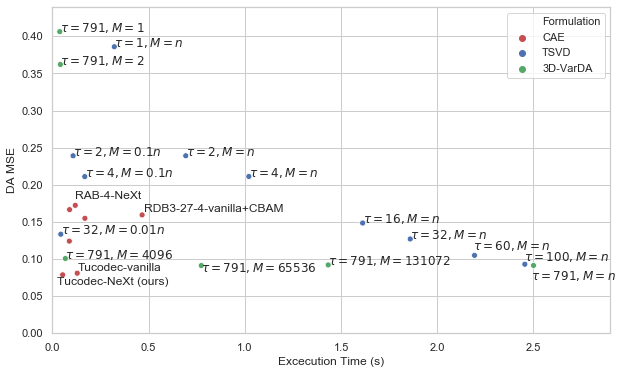

In [27]:
ax = sns.scatterplot(x="time", y="da_mse",
             hue="Formulation", #style="Subset", 
             data=df, palette=["r", "b", 'g',], marker="o")

x = df["time"].copy().astype(float)
y = df["da_mse"].copy().astype(float)
text = df["Model"]
ax.set_xlabel("Excecution Time (s)")
ax.set_ylabel("DA MSE")
xmin, xmax = 0.0, 2.9
ymin, ymax = 0, None
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
for i in range(len(df)):
    tex = r"{}".format(text[i]) 
    if "GPU" in tex:
        y[i] += 0.003
    if tex == "Tucodec-vanilla":
        y[i] += 0.003
    if tex == "Tucodec-NeXt":
        y[i] -= 0.013
        x[i] -= 0.03
        tex += (" (ours)")
    if "GRDN" in tex:
        continue
        y[i] -= 0.003
        x[i] += 0.03
    if "RAB" in tex:
        y[i] += 0.008
    if "791, M = n" in tex:
        y[i] -= 0.02
        x[i] -= 0.012
    if "791, M = 655" in tex:
        y[i] -= 0.009
    if "100, M = n" in tex:
        y[i] += 0.005
        x[i] -= 0.005
    if "60, M = n" in tex:
        y[i] += 0.007
        x[i] -= 0.01
    if "ResNeXt" in tex:
        continue
        y[i] -= 0.008
        x[i] += 0.020
    if "RDB3" in tex:
        y[i] += 0.004
        x[i] += 0.010
    if "Backbone" in tex:
        continue
        y[i] -= 0.007
        x[i] += 0.020
    if xmin is not None:
        if x[i] < xmin:
            continue
    if ymin is not None:
        if y[i] < ymin:
            continue 
    if xmax is not None:
        if x[i] > xmax:
            continue       
    if ymax is not None:
        if y[i] > ymax:
            continue  
    
    
    ax.annotate(tex, (x[i], y[i]), fontsize=12)
fig = ax.get_figure()
fig.set_size_inches(10, 6)
fig.savefig(out_fp2)


